### Import

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset, TensorDataset
from torchsummary import summary
import torchvision.transforms as transforms

from torchvision.transforms import v2



In [ ]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'cpu'
)

print(f"Using {device} device")

Using cpu device


## Data extraction and shuffling

In [2]:
image_size = 150 #scaling a constant image size
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

##### Only Two class: tumor`[0]` or no-tumor `[1]`

In [20]:
label_idx = {
    'glioma': 0,
    'meningioma': 0,
    'notumor': 1,
    'pituitary': 0
}

In [3]:
# # dict for 4 classes
# label_idx = {
#     'glioma': 0,
#     'meningioma': 1,
#     'notumor': 2,
#     'pituitary': 3
# }

In [ ]:

X = []
y = []

for i in labels:
    folderPath = os.path.join('data\Training', i)                                  
    for j in os.listdir(folderPath):                                               
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:
            img = cv2.resize(img,(image_size, image_size))                                        # resale the image
            X.append(img)
            y.append(label_idx[i])                                                          # the ith label will the y

for i in labels:
    folderPath = os.path.join('data\Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:
            img = cv2.resize(img,(image_size, image_size))
            X.append(img)
            y.append(label_idx[i])
                                                                

X = np.array(X, dtype = np.float32)
y = np.array(y, dtype = np.float32)



In [22]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

## Train Test Split

In [23]:
X.shape, y.shape

(torch.Size([7023, 150, 150, 3]), torch.Size([7023]))

In [24]:
# split whole dataset into training and test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.15, random_state = 107, shuffle = True)

# split training into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.15, random_state = 42, shuffle = True)

# Augmentation

In [25]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        label = torch.as_tensor(label, dtype=torch.long)
        image = torch.permute(image, (2, 0, 1))
        if self.transform:

            image = self.transform(image)

        return image, label

# Define data augmentations
transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(150)
])



# Prepare datasets with augmentations
train_dataset = AugmentedDataset(X_train, y_train, transform=transform)
val_dataset = AugmentedDataset(X_val, y_val)  # No augmentations for validation
test_dataset = AugmentedDataset(X_test, y_test) #, transform=transforms.ToTensor())  # No augmentations for test



# Train loop

In [26]:
# Training function
def train(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        #batch = 0

        for image, label in train_loader:
            image = image.to(device)  # Move image to device and convert to float
            label = label.to(device)
            outputs = model(image)

            loss = criterion(outputs, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            #total += label.size(0)
            #correct += (predicted == label).sum().item()
            # print(f"Batch no. : {batch}")
            # batch = batch + 1

            outputs_label = torch.argmax(outputs , dim = 1)
            correct += torch.sum(outputs_label == label)
            total += label.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)
                outputs = model(image)
                #output_label = torch.argmax(outputs, dim = 1)
                loss = criterion(outputs, label)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# VGG-16 Model Architecture

In [27]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),  # Adjusted input size to 512*4*4
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x


In [28]:
print(VGG16)

<class '__main__.VGG16'>


# parameters arguments

In [31]:

# initialize model
model_vgg16 = VGG16(num_classes = 2)

# move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16.to(device)

# loss funtion
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr  = 1e-3)

# epoch
epochs  = 100

#batch size
batch_size = 100

# threads
num_workers = 2

In [32]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)#, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)#, pin_memory=True)


In [33]:
device = next(model_vgg16.parameters()).device
print(f"Model is on {device}")

Model is on cuda:0


# VGG-16 Model Training

In [ ]:
# train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(
#     model_vgg16, criterion, optimizer, train_loader, val_loader, epochs) 

Epoch [1/100], Train Loss: 1.3197, Train Acc: 0.3459, Val Loss: 1.1134, Val Acc: 0.4721
Epoch [2/100], Train Loss: 1.0654, Train Acc: 0.5393, Val Loss: 0.9565, Val Acc: 0.6228
Epoch [3/100], Train Loss: 0.9944, Train Acc: 0.5896, Val Loss: 0.9541, Val Acc: 0.5949
Epoch [4/100], Train Loss: 0.9385, Train Acc: 0.6184, Val Loss: 0.8453, Val Acc: 0.6239
Epoch [5/100], Train Loss: 0.9051, Train Acc: 0.6326, Val Loss: 0.9300, Val Acc: 0.6127
Epoch [6/100], Train Loss: 0.8666, Train Acc: 0.6491, Val Loss: 0.9063, Val Acc: 0.6283
Epoch [7/100], Train Loss: 0.8418, Train Acc: 0.6568, Val Loss: 0.8480, Val Acc: 0.6473
Epoch [8/100], Train Loss: 0.8290, Train Acc: 0.6613, Val Loss: 0.6784, Val Acc: 0.7556
Epoch [9/100], Train Loss: 0.7886, Train Acc: 0.6840, Val Loss: 0.7474, Val Acc: 0.7165
Epoch [10/100], Train Loss: 0.7595, Train Acc: 0.7004, Val Loss: 0.6809, Val Acc: 0.7076
Epoch [11/100], Train Loss: 0.7109, Train Acc: 0.7191, Val Loss: 0.6125, Val Acc: 0.7913
Epoch [12/100], Train Loss: 0.

# Plot

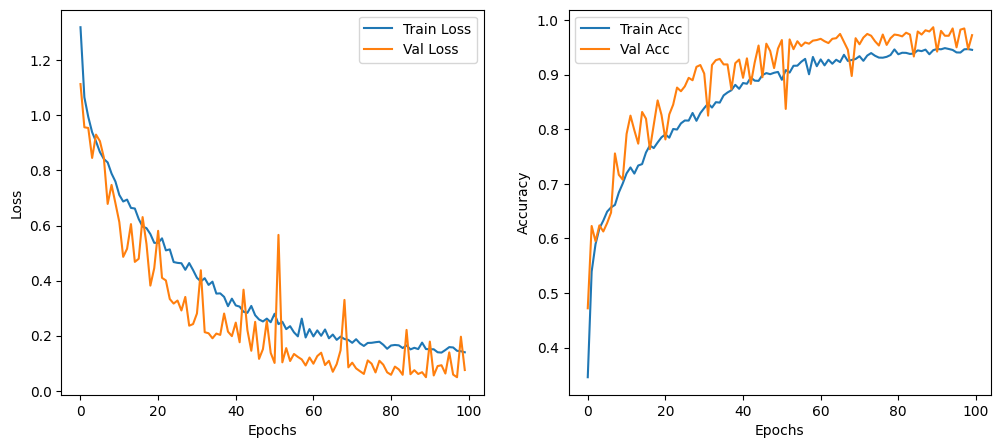

In [ ]:
# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Move the loss history to CPU and convert to NumPy arrays before plotting
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in train_loss_history]), label='Train Loss')
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in val_loss_history]), label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Move the accuracy history to CPU and convert to NumPy arrays before plotting
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in train_acc_history]), label='Train Acc')
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in val_acc_history]), label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Load vgg16_2 class

In [36]:
vgg16_2_class = torch.load('model\\vgg_16_model_2_classes.pt')

In [37]:
vgg16_2_class.cpu()

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

### Classification Report 

In [41]:
X_test = torch.permute(X_test, (0,  3,  2, 1))
# Make predictions on the test set
y_pred_2 = vgg16_2_class(X_test.cpu())

# Convert the predictions to class labels
y_pred_2_classes = torch.argmax(y_pred_2, dim=1)

# Import necessary libraries


# Create a classification report
report_2 = classification_report(y_test, y_pred_2_classes)

# Print the classification report
print(report_2)


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       733
         1.0       0.85      0.99      0.91       321

    accuracy                           0.94      1054
   macro avg       0.92      0.96      0.94      1054
weighted avg       0.95      0.94      0.94      1054



### Confusion Matrix 

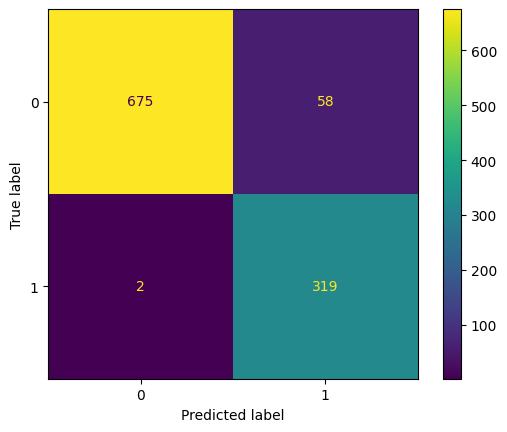

[[675  58]
 [  2 319]]


In [42]:
# Create a confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2_classes)
ConfusionMatrixDisplay(cm_2).plot()
plt.show()

# Print the confusion matrix
print(cm_2)